#  Diffusion and Flow Matching Experiment on mixture of Gaussian

## Overview

This experiment compares two distinct generative modeling techniques: Denoising Diffusion Probabilistic Models (DDPM) and Flow Matching. Both models are implemented using similar transformer-based architectures and are trained on a mixture of Gaussian distributions dataset to ensure a fair comparison.

## 1. Denoising Diffusion Probabilistic Models (DDPM)

### Core Concepts and Intuition

Diffusion models work by gradually adding noise to data through a forward process and then learning to reverse this process. The key insight is that it's easier to learn small, stepwise denoising than to directly generate complex data.

Key components:
- Forward Process: Gradually adds Gaussian noise to data
- Reverse Process: Learns to iteratively remove noise
- Score Function: Gradient of log probability density
- Time Conditioning: Models learn noise level-specific behavior

### Mathematical Foundation

DDPMs are based on the principles of inversing (approximately) the process of Ornstein–Uhlenbeck forward-time SDE. They define a Markov chain that gradually adds noise to the data until it becomes pure noise (forward diffusion process). A neural network is then trained to reverse this process, gradually denoising the data back to its original form (backward diffusion process).

The forward process is defined as:

$$
q(x_{1:T}|x_0) = \prod_{t=1}^{T} q(x_t|x_{t-1})
$$

where

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})
$$

The backward process is learned to approximate:

$$
p_{\theta}(x_{0:T}) = p(x_T) \prod_{t=1}^{T} p_{\theta}(x_{t-1}|x_t)
$$

where

$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

### Algorithmic Implementation

The implementation involves:

1.  **Forward Diffusion Process:** Adding Gaussian noise to the data over T steps.
    - For each timestep t:
      * Sample noise ε ~ N(0,I)
      * Compute noisy data: xₜ = √ᾱₜx₀ + √(1-ᾱₜ)ε

2.  **Backward Diffusion Process:** Training a neural network to predict the noise added in the forward process and reverse the diffusion (noise score matching)
    - Network learns ε_θ(xₜ,t) ≈ ε
    - Uses U-Net architecture with time embedding
    - Minimizes mean squared error loss

3.  **Sampling:** Generating new samples by starting from random noise and iteratively denoising using the trained network.
    - Start with xₜ ~ N(0,I)
    - For each timestep t from T to 1:
      * Predict noise ε_θ(xₜ,t)
      * Apply denoising update equation
      * Add scaled noise if t > 0

## 2. Flow Matching

### Mathematical Foundation

Flow Matching is a generative modeling technique that learns a continuous transformation (a flow) to map a simple distribution (e.g., Gaussian noise) to a complex data distribution. It involves learning a time-dependent vector field that defines the flow.

The core idea is to learn a vector field $u_t(x)$ such that the solution to the ordinary differential equation (ODE):

$$
\frac{d x_t}{dt} = u_t(x_t)
$$

transforms a sample from a source distribution $p_0$ to a sample from the target distribution $p_1$.

### Algorithmic Implementation

The implementation involves:

1.  **Defining a Probability Path:** Constructing a path that smoothly interpolates between the source and target distributions. 
    - x(t) = (1-t)z + tx where:
      * z ~ N(0,I) (source)
      * x ~ p_data (target)
      * t ∈ [0,1] (interpolation parameter)
2.  **Learning a Vector Field:** Training a neural network to estimate the vector field that generates the probability path.
    - Neural network u_θ(x,t) learns optimal velocity
    - Architecture includes:
      * Time embedding
      * Position encoding
      * Transformer blocks for feature extraction
      * Final projection to vector
3.  **Sampling:** Generating new samples by solving the ODE using the learned vector field, starting from a sample from the source distribution.
    - Start with z ~ N(0,I)
    - Solve ODE with learned vector field:
      * Use numerical integrator (e.g., Euler)
      * Step through time from t=0 to t=1
      * Each step updates position using u_θ

## Comparison

| Feature             | DDPM                                  | Flow Matching                             |
|----------------------|----------------------------------------|------------------------------------------|
| Process              | Forward and backward diffusion        | Continuous transformation (flow)          |
| Training Objective   | Noise prediction                      | Vector field learning                     |
| Sampling             | Iterative denoising                     | ODE solving                               |
| Architectural Basis | Transformer-based UNet                | Transformer-based architecture            |
| Data Distribution    | Mixture of Gaussian distributions     | Mixture of Gaussian distributions         |

Both models are evaluated using metrics such as KL divergence, JS divergence, and Wasserstein distance to compare the generated distributions with the target distribution.

In [1]:
# Global constants for model configuration
DIFFUSION_STEPS = 100  # Number of steps for diffusion process
FLOW_STEPS = 100        # Number of steps for flow generation

FLOW_VIS_STEPS = 5     # Number of visualization steps for flow evolution

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import tqdm

/home/edwin/Projects/GM_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
def generate_mixture_data(num_samples=256, num_points=100, range_min=-5, range_max=5):
    """
    Generate samples from a mixture of Gaussian distributions.

    Args:
        num_samples (int): Number of samples to generate
        num_points (int): Number of points per sample
        range_min (float): Minimum x value
        range_max (float): Maximum x value

    Returns:
        tuple: (samples, x_values) where samples has shape [num_samples, num_points]
    """
    # Generate x values
    x = torch.linspace(range_min, range_max, num_points)

    # Generate mixture parameters
    components = [
        {'mean_range': (-3, -1), 'sigma': 0.5},
        {'mean_range': (1, 3), 'sigma': 0.5}
    ]

    # Generate data
    p = torch.zeros(num_samples, num_points)
    for comp in components:
        mean_range = comp['mean_range']
        sigma = comp['sigma']
        mu = torch.rand(num_samples) * (mean_range[1] - mean_range[0]) + mean_range[0]
        component_p = torch.exp(-(x.unsqueeze(0) - mu.unsqueeze(1))**2 / (2 * sigma**2)) / (sigma * math.sqrt(2 * math.pi))
        p += component_p

    # Normalize to [-1, 1]
    min_vals, _ = p.min(dim=1, keepdim=True)
    max_vals, _ = p.max(dim=1, keepdim=True)
    p = 2 * (p - min_vals) / (max_vals - min_vals) - 1

    return p, x

def generate_and_save_datasets(num_train=4000, num_test=1000, seed=42):
    """
    Generate and save training and test datasets.

    Args:
        num_train (int): Number of training samples
        num_test (int): Number of test samples
        seed (int): Random seed for reproducibility
    """
    # Set seed for reproducibility
    torch.manual_seed(seed)

    print("Generating training data...")
    train_data, x_coords = generate_mixture_data(num_train)

    print("Generating test data...")
    test_data, _ = generate_mixture_data(num_test)

    print("Saving datasets...")
    torch.save({
        'train_data': train_data,
        'test_data': test_data,
        'x_coords': x_coords,
        'metadata': {
            'num_train': num_train,
            'num_test': num_test,
            'seed': seed
        }
    }, 'mixture_datasets.pt')

    print("Datasets saved successfully!")
    return train_data, test_data, x_coords

In [3]:
class DistributionMetrics:
    """
    Collection of metrics for comparing probability distributions.
    All methods expect input tensors of shape [batch_size, num_points].
    """

    @staticmethod
    def kl_divergence(p, q, epsilon=1e-10):
        """
        Compute Kullback-Leibler divergence between p and q.

        Args:
            p (torch.Tensor): First distribution
            q (torch.Tensor): Second distribution
            epsilon (float): Small constant for numerical stability

        Returns:
            torch.Tensor: KL(P||Q) for each sample in the batch
        """
        # Ensure valid probability distributions
        p = F.softmax(p, dim=-1)
        q = F.softmax(q, dim=-1)

        # Add small epsilon to avoid log(0)
        p = p + epsilon
        q = q + epsilon

        # Normalize
        p = p / p.sum(dim=-1, keepdim=True)
        q = q / q.sum(dim=-1, keepdim=True)

        return torch.sum(p * torch.log(p / q), dim=-1)

    @staticmethod
    def js_divergence(p, q, epsilon=1e-10):
        """
        Compute Jensen-Shannon divergence between p and q.

        Args:
            p (torch.Tensor): First distribution
            q (torch.Tensor): Second distribution
            epsilon (float): Small constant for numerical stability

        Returns:
            torch.Tensor: JS(P||Q) for each sample in the batch
        """
        # Ensure valid probability distributions
        p = F.softmax(p, dim=-1)
        q = F.softmax(q, dim=-1)

        # Add small epsilon to avoid log(0)
        p = p + epsilon
        q = q + epsilon

        # Normalize
        p = p / p.sum(dim=-1, keepdim=True)
        q = q / q.sum(dim=-1, keepdim=True)

        # Compute midpoint distribution
        m = 0.5 * (p + q)

        # JS = 0.5 * (KL(P||M) + KL(Q||M))
        js_p = torch.sum(p * torch.log(p / m), dim=-1)
        js_q = torch.sum(q * torch.log(q / m), dim=-1)

        return 0.5 * (js_p + js_q)

    @staticmethod
    def wasserstein_distance(p, q):
        """
        Compute Wasserstein distance between p and q using their empirical CDFs.

        Args:
            p (torch.Tensor): First distribution
            q (torch.Tensor): Second distribution

        Returns:
            torch.Tensor: Wasserstein distance for each sample in the batch
        """
        # Compute empirical CDFs
        p_cdf = torch.cumsum(F.softmax(p, dim=-1), dim=-1)
        q_cdf = torch.cumsum(F.softmax(q, dim=-1), dim=-1)

        # Return L1 distance between CDFs
        return torch.sum(torch.abs(p_cdf - q_cdf), dim=-1)

    @staticmethod
    def compute_all_metrics(p, q):
        """
        Compute all available metrics between p and q.

        Args:
            p (torch.Tensor): First distribution
            q (torch.Tensor): Second distribution

        Returns:
            dict: Dictionary containing all computed metrics
        """
        return {
            'kl_divergence': DistributionMetrics.kl_divergence(p, q).mean().item(),
            'js_divergence': DistributionMetrics.js_divergence(p, q).mean().item(),
            'wasserstein': DistributionMetrics.wasserstein_distance(p, q).mean().item()
        }

def evaluate_generated_samples(generated, target):
    """
    Evaluate generated samples against target samples using multiple metrics.

    Args:
        generated (torch.Tensor): Generated samples [batch_size, num_points]
        target (torch.Tensor): Target samples [batch_size, num_points]

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    return DistributionMetrics.compute_all_metrics(generated, target)

## Dataset Loading and Preprocessing

In [4]:
class MixtureDataset(Dataset):
    """Dataset wrapper for mixture distribution samples."""
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def load_datasets():
    """Load pre-generated mixture datasets."""
    data = torch.load('mixture_datasets.pt')
    return data['train_data'], data['test_data'], data['x_coords']

## Model Components

Both models share common architectural components (attention mechanisms and transformer blocks).

In [5]:
class HeadAttention(nn.Module):
    """Single attention head for transformer architecture."""
    def __init__(self, d, d_head, dropout=0.01):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(dropout)

    def forward(self, x):
        Q = self.Q(x).unsqueeze(2)     # [bs, n, 1, d_head]
        K = self.K(x).unsqueeze(1)     # [bs, 1, n, d_head]
        V = self.V(x)                  # [bs, n, d_head]

        Att = (Q * K).sum(dim=3) / self.sqrt_d  # [bs, n, n]
        Att = torch.softmax(Att, dim=1)         # [bs, n, n]
        Att = self.drop_att(Att)               # [bs, n, n]

        return Att @ V                         # [bs, n, d_head]

class MultiHeadAttention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, d, num_heads, dropout=0.01):
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList([HeadAttention(d, d_head, dropout) for _ in range(num_heads)])
        self.WO = nn.Linear(d, d)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x_heads = [head(x) for head in self.heads]
        x = self.WO(torch.cat(x_heads, dim=2))
        return self.drop(x)

class TransformerBlock(nn.Module):
    """Transformer block with multi-head attention and feedforward network."""
    def __init__(self, d, num_heads, dropout=0.01):
        super().__init__()
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)
        self.mha = MultiHeadAttention(d, num_heads, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d, 4*d),
            nn.ReLU(),
            nn.Linear(4*d, d)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention
        x = x + self.mha(self.norm1(x))
        # Feedforward network
        x = x + self.drop(self.ffn(self.norm2(x)))
        return x

## Diffusion Model Implementation

In [6]:
class UNet(nn.Module):
    """UNet architecture for denoising diffusion model."""
    def __init__(self, num_steps, dim=64, h_dim=256, n_heads=2, n_layers=2, dropout=0.01):
        super().__init__()
        # 1. Time embedding: Embeds the timestep t into a higher-dimensional space.
        self.time_embed = nn.Sequential(
            nn.Embedding(num_steps, h_dim),  # Embed each timestep to a h_dim vector
            nn.ReLU(),                       # Apply ReLU activation
            nn.Linear(h_dim, dim)            # Project to the model dimension dim
        )

        # 2. Position embedding: Embeds the position of each point in the input sequence.
        #    This helps the model understand the structure of the input.
        self.pos_embed = nn.Embedding(100, dim)  # Fixed for 100 points

        # 3. Input projection: Projects the input (which is 1-dimensional in this case) to the model dimension dim.
        self.input_proj = nn.Linear(1, dim)

        # 4. Transformer layers: A series of transformer blocks that process the embedded input.
        #    These layers learn to extract features and denoise the input.
        self.layers = nn.ModuleList([
            TransformerBlock(dim, n_heads, dropout)  # Create a list of TransformerBlock layers
            for _ in range(n_layers)
        ])

        # 5. Output projection: Projects the output of the transformer layers back to the original input dimension (1).
        self.norm_final = nn.LayerNorm(dim)
        self.output_proj = nn.Linear(dim, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, t):
        """
        Forward pass of the UNet model.

        Args:
            x (torch.Tensor): Input tensor [batch_size, n_points].
            t (torch.Tensor): Timestep tensor [batch_size].

        Returns:
            torch.Tensor: Output tensor [batch_size, n_points].
        """
        # 1. Shape [batch_size, n_points] -> [batch_size, n_points, 1]: Add a channel dimension
        x = x.unsqueeze(-1)

        # 2. Input embedding: Project the input to the model dimension
        h = self.input_proj(x)  # [batch_size, n_points, dim]

        # 3. Add positional embedding: Add positional information to the input
        pos = torch.arange(x.shape[1], device=x.device)  # Create a range of positions
        h = h + self.pos_embed(pos).unsqueeze(0)         # Add position embeddings

        # 4. Add time embedding: Add time information to the input
        t_emb = self.time_embed(t)  # [batch_size, dim]
        h = h + t_emb.unsqueeze(1)   # Add time embeddings

        # 5. Apply transformer layers: Process the input with a series of transformer blocks
        for layer in self.layers:
            h = layer(h)  # Apply each transformer block

        # 6. Output projection: Project the output back to the original dimension
        h = self.norm_final(h)    # Apply Layer Normalization
        output = self.output_proj(h)  # Project to the original dimension

        return output.squeeze(-1)  # Remove the last dimension

class DDPM(nn.Module):
    """Denoising Diffusion Probabilistic Model."""
    def __init__(self, num_steps, beta_1, beta_T, device='cuda'):
        """
        Initialize the DDPM model.

        Args:
            num_steps (int): Number of diffusion steps.
            beta_1 (float): Initial value of beta (noise schedule).
            beta_T (float): Final value of beta (noise schedule).
            device (str): Device to use (cuda or cpu).
        """
        super().__init__()
        self.num_steps = num_steps
        self.device = device

        # 1. Define noise schedule: Linearly increasing variance schedule
        # Beta values control the amount of noise added at each diffusion step
        self.beta = torch.linspace(beta_1, beta_T, num_steps).to(device)  # Linear schedule for beta
        # Alpha values are defined as 1 - beta, representing the remaining signal after adding noise
        self.alpha = 1 - self.beta                                        # Alpha = 1 - Beta
        # Alpha_bar values are the cumulative product of alpha, representing the overall signal decay
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)                  # Cumulative product of alpha values

        # 2. Create UNet model with matching step count: The core denoising network
        self.model = UNet(num_steps).to(device)

    def forward_process(self, x_0, t, eps=None):
        """
        Forward diffusion process: Adds noise to the input data.

        This process gradually adds Gaussian noise to the input data (x_0) over a series of timesteps (t)
        until the data becomes pure noise.

        Args:
            x_0 (torch.Tensor): Initial data [batch_size, num_points].
            t (torch.Tensor): Timestep [batch_size].
            eps (torch.Tensor): Noise (optional).

        Returns:
            tuple: Noisy data at timestep t and the noise added.
        """
        # Sample noise if not provided
        if eps is None:
            eps = torch.randn_like(x_0)

        # Calculate alpha_bar for the given timestep
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)

        # Add noise to the input data
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * eps

        return x_t, eps

    def backward_process(self, x_t, t):
        """
        Predict noise in backward diffusion process.

        This process uses the UNet model to predict the noise that was added to the data during the forward process.

        Args:
            x_t (torch.Tensor): Noisy data at timestep t [batch_size, num_points].
            t (torch.Tensor): Timestep [batch_size].

        Returns:
            torch.Tensor: Predicted noise [batch_size, num_points].
        """
        # Use the UNet model to predict the noise
        return self.model(x_t, t)

    def generate_samples(self, num_samples, device, x_coords):
        """
        Generate new samples using the trained model.

        This process starts from pure noise and iteratively denoises it using the trained UNet model
        to generate new samples.

        Args:
            num_samples (int): Number of samples to generate.
            device (str): Device to use (cuda or cpu).
            x_coords (torch.Tensor): X coordinates for plotting.

        Returns:
            torch.Tensor: Generated samples [num_samples, num_points].
        """
        with torch.no_grad():
            # Start from pure noise: Sample from a Gaussian distribution
            x_t = torch.randn(num_samples, len(x_coords)).to(device)

            # Gradually denoise: Iterate from T to 1
            for t in range(self.num_steps - 1, -1, -1):
                # Create a batch of timesteps
                t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

                # Predict the noise
                predicted_noise = self.backward_process(x_t, t_batch)

                # Compute parameters for denoising step
                alpha_t = self.alpha[t]
                alpha_bar_t = self.alpha_bar[t]
                beta_t = self.beta[t]

                # Add noise (except for the last step)
                if t > 0:
                    noise = torch.randn_like(x_t)
                else:
                    noise = 0

                # Apply denoising step (reverse diffusion process)
                x_t = (1 / torch.sqrt(alpha_t)) * (
                    x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
                ) + torch.sqrt(beta_t) * noise

        return x_t

## Flow Matching Model Implementation

In [7]:
class Flow(nn.Module):
    """Flow Matching model with transformer-based architecture."""
    def __init__(self, dim: int = 64, h_dim: int = 256, num_heads: int = 2, num_layers: int = 2, dropout: float = 0.01):
        super().__init__()
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, dim)
        )

        # Position embedding
        self.pos_embed = nn.Embedding(100, dim)  # Fixed for 100 points

        # Input projection
        self.input_proj = nn.Linear(1, dim)

        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerBlock(dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

        # Output projection
        self.norm_final = nn.LayerNorm(dim)
        self.output_proj = nn.Linear(dim, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, t: torch.Tensor, x_t: torch.Tensor) -> torch.Tensor:
        # Shape [batch_size, n_points] -> [batch_size, n_points, 1]
        x = x_t.unsqueeze(-1)

        # Input embedding
        h = self.input_proj(x)  # [batch_size, n_points, dim]

        # Add positional embedding
        pos = torch.arange(x.shape[1], device=x.device)
        h = h + self.pos_embed(pos).unsqueeze(0)

        # Add time embedding
        t_emb = self.time_embed(t.view(-1, 1))  # [batch_size, dim]
        h = h + t_emb.unsqueeze(1)

        # Apply transformer layers
        for layer in self.layers:
            h = layer(h)

        # Output projection
        h = self.norm_final(h)
        output = self.output_proj(h)

        return output.squeeze(-1)

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        bs = x_t.shape[0]
        t_start = t_start.expand(bs)
        t_end = t_end.expand(bs)
        dt = (t_end - t_start).unsqueeze(-1)

        # Midpoint method with improved stability
        t_mid = t_start + dt.squeeze(-1)/2
        dx_start = self(t=t_start, x_t=x_t)
        x_mid = x_t + dx_start * dt
        dx_mid = self(t=t_mid, x_t=x_mid)

        return x_t + dx_mid * dt

## Training Functions

In [8]:
def train_diffusion(num_epochs=100, batch_size=1024, save_interval=50, device='cuda'):
    """Train the diffusion model on mixture distribution data."""
    print("Loading datasets...")
    train_data, test_data, x_coords = load_datasets()
    x_coords = x_coords.to(device)

    # Create datasets and dataloaders
    train_dataset = MixtureDataset(train_data)
    test_dataset = MixtureDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model (using global constant)
    beta_1 = 1e-4
    beta_T = 0.02

    model = DDPM(DIFFUSION_STEPS, beta_1, beta_T, device=device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=5)

    # Training loop
    train_losses = []
    print("\nTraining started...")
    pbar = tqdm(range(num_epochs), desc="Training")

    for epoch in pbar:
        model.train()
        batch_losses = []

        for x_0 in train_loader:
            x_0 = x_0.to(device)
            t = torch.randint(0, DIFFUSION_STEPS, (len(x_0),), device=device)

            # Forward process
            noise = torch.randn_like(x_0)
            x_t, eps = model.forward_process(x_0, t, noise)

            # Predict noise
            predicted_noise = model.backward_process(x_t, t)

            # Compute loss
            loss = torch.nn.functional.mse_loss(predicted_noise, eps)

            # Update model
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            batch_losses.append(loss.item())

        # Update progress
        avg_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(avg_loss)
        pbar.set_postfix({'loss': f'{avg_loss:.6f}'})
        scheduler.step(avg_loss)

        # Visualize progress
        if (epoch + 1) % save_interval == 0:
            plot_diffusion_progress(train_losses, epoch + 1)
            evaluate_diffusion_samples(model, x_coords, test_data, device)

    print("\nDiffusion model training completed!")
    return model, x_coords, train_losses

def train_flow(num_epochs=100, batch_size=1024, save_interval=50, device='cuda'):
    """Train the flow matching model on mixture distribution data."""
    print("Loading datasets...")
    train_data, test_data, x_coords = load_datasets()
    train_data = train_data.to(device)
    test_data = test_data.to(device)
    x_coords = x_coords.to(device)

    train_dataset = MixtureDataset(train_data)
    test_dataset = MixtureDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    flow = Flow().to(device)
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=5)
    loss_fn = nn.MSELoss()

    train_losses = []

    print("Training started...")
    pbar = tqdm(range(num_epochs), desc="Training")
    for epoch in pbar:
        batch_losses = []

        for x_1 in train_loader:
            x_1 = x_1.to(device)
            x_0 = torch.randn_like(x_1, device=device)
            t = torch.rand(len(x_1), device=device)

            x_t = (1 - t.unsqueeze(-1)) * x_0 + t.unsqueeze(-1) * x_1
            dx_t = x_1 - x_0

            optimizer.zero_grad()
            pred = flow(t=t, x_t=x_t)
            loss = loss_fn(pred, dx_t)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(flow.parameters(), 1.0)
            optimizer.step()

            batch_losses.append(loss.item())

        avg_epoch_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(avg_epoch_loss)

        # Update learning rate
        scheduler.step(avg_epoch_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{avg_epoch_loss:.6f}',
            'lr': f'{current_lr:.2e}'
        })

        if (epoch + 1) % save_interval == 0:
            plot_flow_progress(train_losses, epoch+1)
            evaluate_flow_samples(flow, x_coords, test_data, device)

    print("\nFlow matching model training completed!")
    return flow, x_coords, test_data, train_losses

## Visualization and Evaluation Functions

In [9]:
def plot_diffusion_progress(losses, epoch):
    """Plot training progress for diffusion model."""
    plt.figure(figsize=(8, 5))
    plt.plot(losses)
    plt.title(f'Diffusion Training Loss\nEpoch {epoch}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.show()

def plot_flow_progress(losses, epoch):
    """Plot training progress for flow matching model."""
    plt.figure(figsize=(8, 5))
    plt.plot(losses)
    plt.title(f'Flow Matching Training Loss\nEpoch {epoch}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.show()

def evaluate_diffusion_samples(diffusion_model, x_coords, test_data, device):
    """Generate and visualize a single diffusion sample."""
    diffusion_model.eval()
    with torch.no_grad():
        # Generate one sample
        generated_sample = diffusion_model.generate_samples(1, device, x_coords)

        # Plot single sample
        plt.figure(figsize=(10, 5))
        plt.plot(x_coords.cpu(), generated_sample[0].cpu(), 'b-', label='Generated sample')
        plt.title('Single Diffusion Generated Sample')
        plt.ylim(-2.0, 2.0)
        plt.grid(True)
        plt.legend()
        plt.show()

def evaluate_flow_samples(flow_model, x_coords, test_data, device):
    """Generate and visualize a single flow matching sample."""
    flow_model.eval()
    with torch.no_grad():
        # Generate one sample with intermediate steps
        x_sample = torch.randn(1, len(x_coords), device=device)
        time_steps = torch.linspace(0, 1.0, FLOW_STEPS, device=device)

        plt.figure(figsize=(15, 5))
        plt.plot(x_coords.cpu(), x_sample[0].cpu(), 'r--', alpha=0.5, label='Initial noise')

        for i in range(len(time_steps)-1):
            x_sample = flow_model.step(
                x_t=x_sample,
                t_start=time_steps[i],
                t_end=time_steps[i+1]
            )

            if i == len(time_steps)-2:  # Plot only final sample
                plt.plot(x_coords.cpu(), x_sample[0].cpu(), 'b-', label='Generated sample')

        plt.title('Single Flow Matching Sample Generation')
        plt.ylim(-2.0, 2.0)
        plt.grid(True)
        plt.legend()
        plt.show()

def visualize_flow_evolution(flow, x_coords, device=None):
    """Visualize flow matching model's sample generation process."""
    if device is None:
        device = x_coords.device

    # Generate a single sample
    x_sample = torch.randn(1, len(x_coords), device=device)

    # Generate all time steps
    time_steps = torch.linspace(0, 1.0, FLOW_STEPS + 1, device=device)

    # Plot evolution
    fig, axes = plt.subplots(1, FLOW_VIS_STEPS, figsize=(20, 4))
    step_indices = [0, FLOW_STEPS//4, FLOW_STEPS//2, 3*FLOW_STEPS//4, FLOW_STEPS]

    # Initial noise
    axes[0].plot(x_coords.cpu(), x_sample[0].cpu(), 'r--', label='Initial noise')
    axes[0].set_title('t = 0.0')
    axes[0].set_ylim(-2.0, 2.0)
    axes[0].grid(True)
    axes[0].legend()

    current_sample = x_sample
    for t_idx in range(1, FLOW_STEPS + 1):
        current_sample = flow.step(
            x_t=current_sample,
            t_start=time_steps[t_idx-1],
            t_end=time_steps[t_idx]
        )

        if t_idx in step_indices[1:]:
            plot_idx = step_indices.index(t_idx)
            axes[plot_idx].plot(x_coords.cpu(), current_sample[0].cpu(), 'b-', label='Sample')
            axes[plot_idx].set_title(f't = {time_steps[t_idx]:.1f}')
            axes[plot_idx].set_ylim(-2.0, 2.0)
            axes[plot_idx].grid(True)
            axes[plot_idx].legend()

    plt.suptitle('Flow Matching: Single Sample Evolution', y=1.05)
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.85, wspace=0.3)
    plt.show()

In [10]:
def plot_model_distributions(diffusion_model, flow_model, x_coords, test_data, device, num_samples=100):
    """Compare distributions of both models using mean/std visualization."""
    print("\nGenerating distribution comparison plots...")
    diffusion_model.eval()
    flow_model.eval()

    with torch.no_grad():
        # Generate samples
        diffusion_samples = diffusion_model.generate_samples(num_samples, device, x_coords)

        flow_samples = torch.randn(num_samples, len(x_coords), device=device)
        time_steps = torch.linspace(0, 1.0, FLOW_STEPS, device=device)
        for i in range(len(time_steps)-1):
            flow_samples = flow_model.step(
                x_t=flow_samples,
                t_start=time_steps[i],
                t_end=time_steps[i+1]
            )

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot means and std for both models
        # Diffusion distribution
        axes[0].plot(x_coords.cpu(), diffusion_samples.cpu().mean(dim=0), 'b-', label='Diffusion (mean)')
        axes[0].fill_between(
            x_coords.cpu(),
            diffusion_samples.cpu().mean(dim=0) - diffusion_samples.cpu().std(dim=0),
            diffusion_samples.cpu().mean(dim=0) + diffusion_samples.cpu().std(dim=0),
            alpha=0.2,
            color='b',
            label='Diffusion (±1 std)'
        )

        # Flow matching distribution
        axes[0].plot(x_coords.cpu(), flow_samples.cpu().mean(dim=0), 'r-', label='Flow (mean)')
        axes[0].fill_between(
            x_coords.cpu(),
            flow_samples.cpu().mean(dim=0) - flow_samples.cpu().std(dim=0),
            flow_samples.cpu().mean(dim=0) + flow_samples.cpu().std(dim=0),
            alpha=0.2,
            color='r',
            label='Flow (±1 std)'
        )

        # Target distribution
        axes[0].plot(x_coords.cpu(), test_data.cpu().mean(dim=0), 'k--', label='Target (mean)')
        axes[0].fill_between(
            x_coords.cpu(),
            test_data.cpu().mean(dim=0) - test_data.cpu().std(dim=0),
            test_data.cpu().mean(dim=0) + test_data.cpu().std(dim=0),
            alpha=0.2,
            color='gray',
            label='Target (±1 std)'
        )

        axes[0].set_title('Distribution Comparison (Mean ± Std)')
        axes[0].grid(True)
        axes[0].legend()
        axes[0].set_ylim(-2.0, 2.0)

        # Single sample comparison
        axes[1].plot(x_coords.cpu(), diffusion_samples[0].cpu(), 'b-', label='Diffusion sample')
        axes[1].plot(x_coords.cpu(), flow_samples[0].cpu(), 'r-', label='Flow sample')
        axes[1].plot(x_coords.cpu(), test_data[0].cpu(), 'k--', label='Target sample')
        axes[1].set_title('Individual Sample Comparison')
        axes[1].grid(True)
        axes[1].legend()
        axes[1].set_ylim(-2.0, 2.0)

        plt.tight_layout()
        plt.show()

        # Compute metrics
        diffusion_metrics = evaluate_generated_samples(diffusion_samples.cpu(), test_data[:num_samples].cpu())
        flow_metrics = evaluate_generated_samples(flow_samples.cpu(), test_data[:num_samples].cpu())

        # Display metrics in a formatted way
        print("\nModel Comparison Metrics:")
        print("-" * 40)
        print(f"{'Metric':<15} {'Diffusion':>10} {'Flow':>10}")
        print("-" * 40)
        for metric in diffusion_metrics.keys():
            print(f"{metric:<15} {diffusion_metrics[metric]:>10.4f} {flow_metrics[metric]:>10.4f}")

## Training and Comparison

In [11]:
_, _, _ = generate_and_save_datasets()

Generating training data...
Generating test data...
Saving datasets...
Datasets saved successfully!


In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train both models
print("\nTraining Diffusion Model...")
diffusion_model, x_coords, diffusion_losses = train_diffusion(device=device)

print("\nTraining Flow Matching Model...")
flow_model, x_coords, test_data, flow_losses = train_flow(device=device)

# Compare final results
plot_model_distributions(diffusion_model, flow_model, x_coords, test_data, device)

To have better results, change hyperparamter, like the number of epochs (takes more time to run):

Using device: cuda

Training Diffusion Model...
Loading datasets...

Training started...


Training:  50%|████▉     | 99/200 [01:57<01:56,  1.15s/it, loss=0.072408]

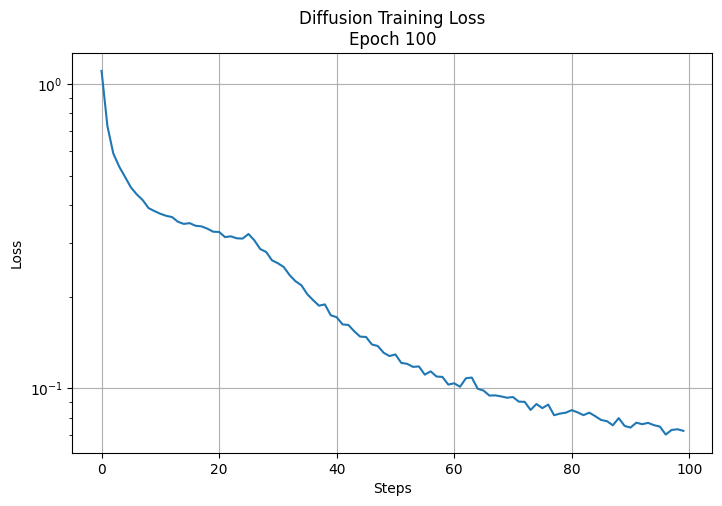

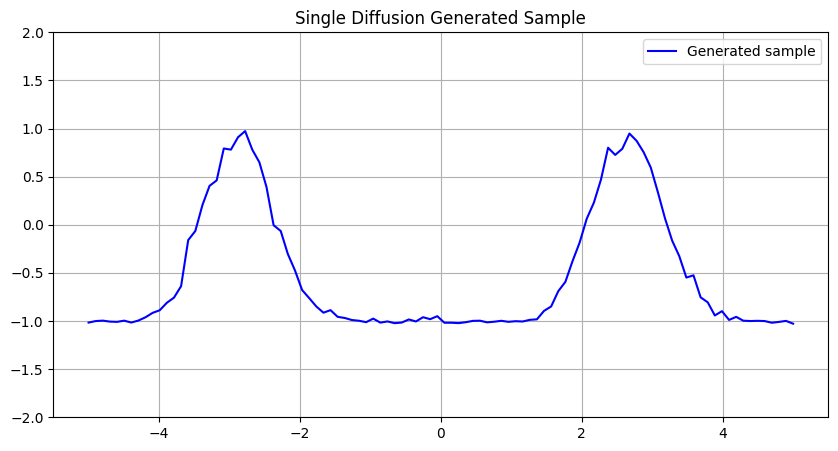

Training: 100%|█████████▉| 199/200 [05:19<00:02,  2.35s/it, loss=0.048414]

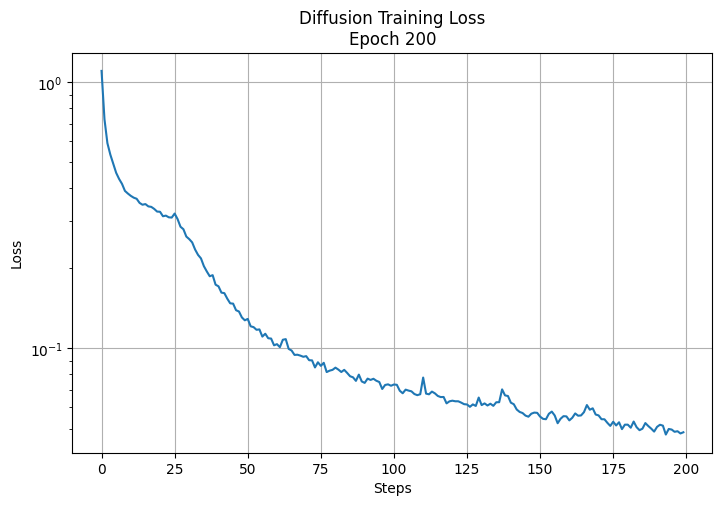

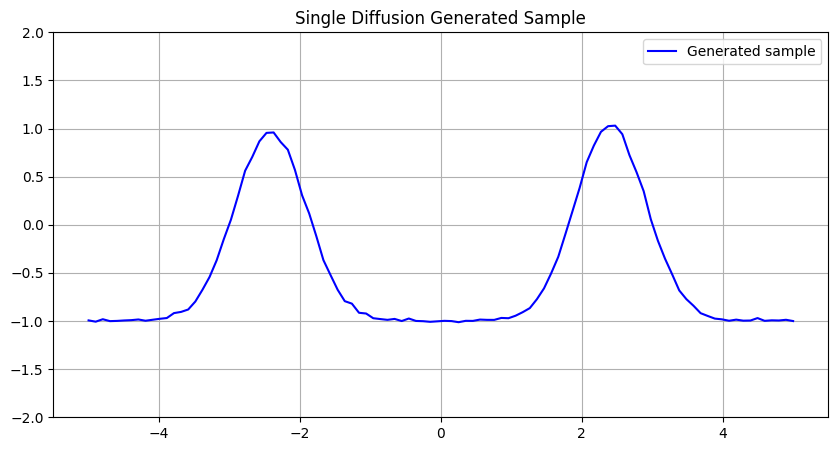

Training: 100%|██████████| 200/200 [05:20<00:00,  1.60s/it, loss=0.048414]



Diffusion model training completed!

Training Flow Matching Model...
Loading datasets...
Training started...


Training:  50%|████▉     | 99/200 [03:57<04:02,  2.40s/it, loss=0.199577, lr=9.50e-04]

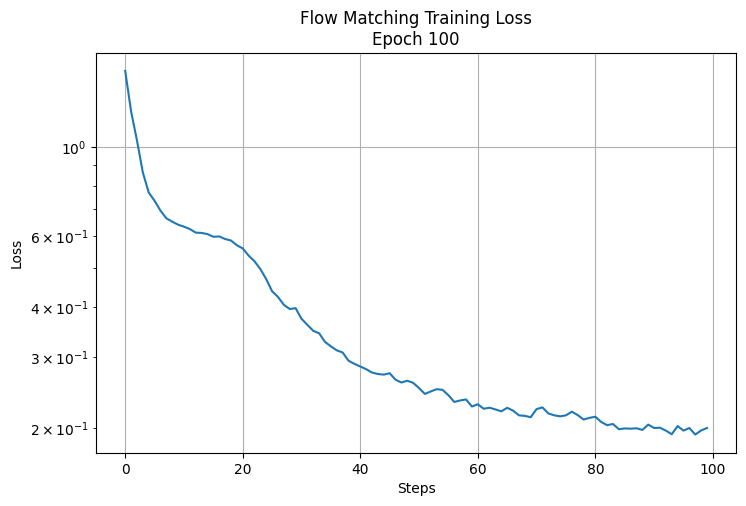

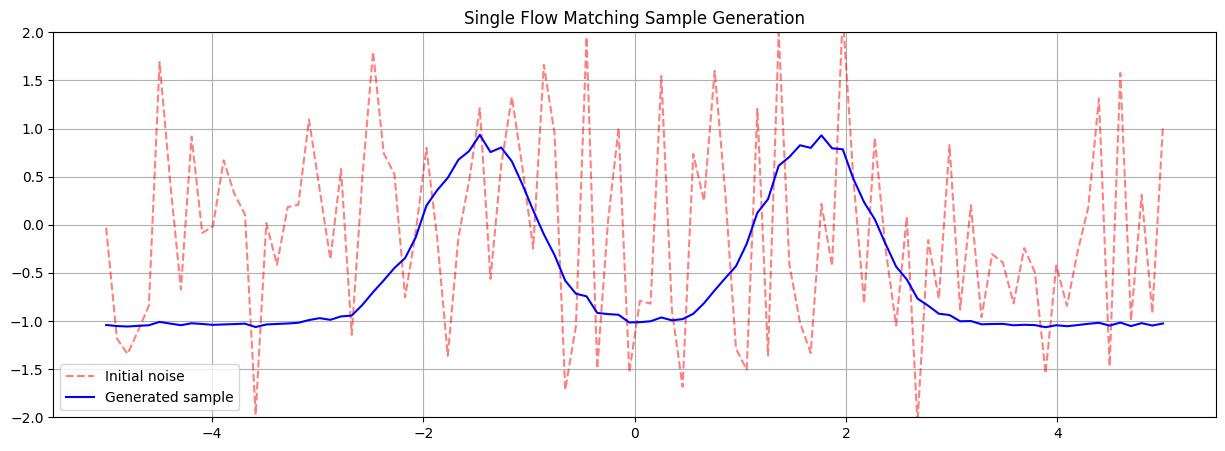

Training: 100%|█████████▉| 199/200 [07:53<00:02,  2.34s/it, loss=0.158294, lr=6.30e-04]

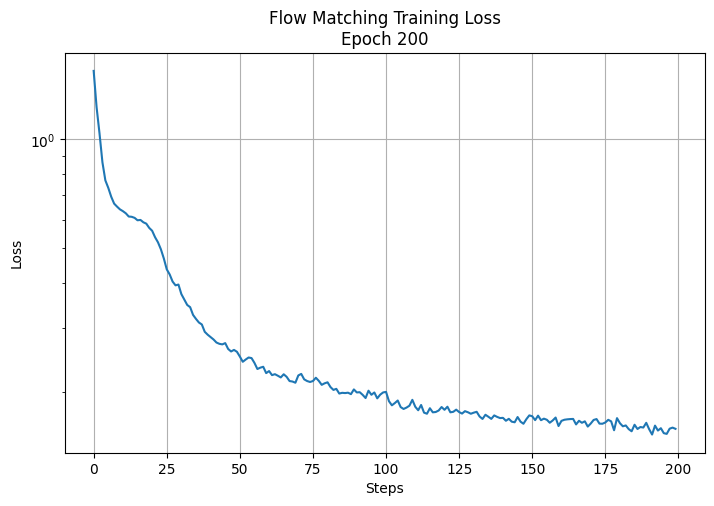

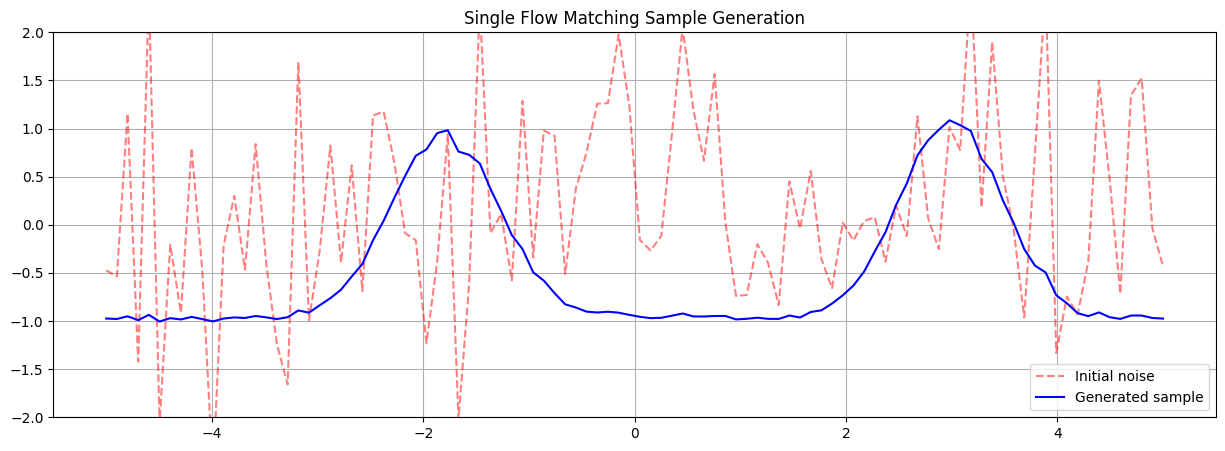

Training: 100%|██████████| 200/200 [07:54<00:00,  2.37s/it, loss=0.158294, lr=6.30e-04]



Flow matching model training completed!

Generating distribution comparison plots...


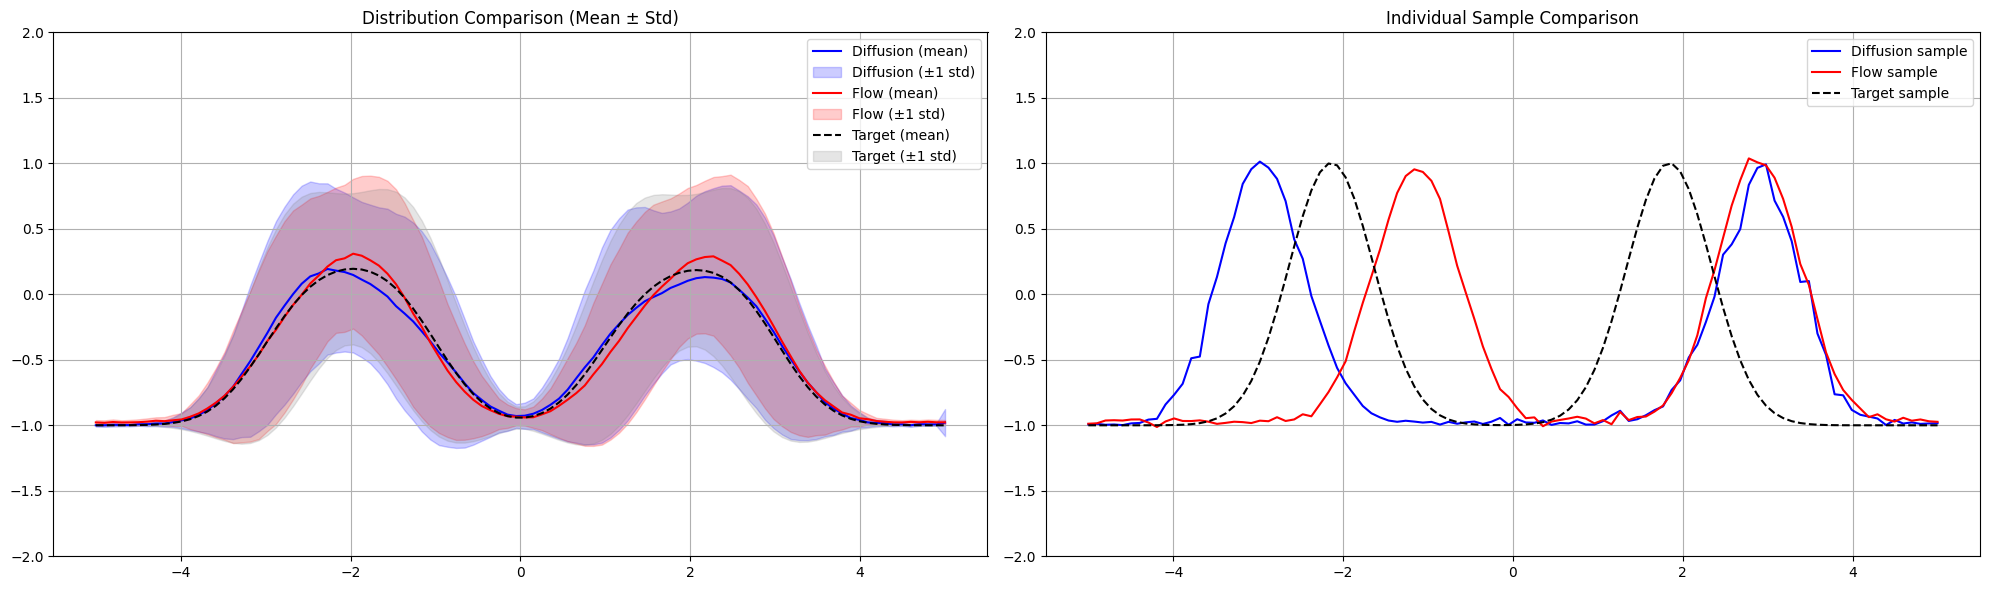


Model Comparison Metrics:
----------------------------------------
Metric           Diffusion       Flow
----------------------------------------
kl_divergence       0.3482     0.3081
js_divergence       0.0800     0.0711
wasserstein         3.7722     3.3344


In [12]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train both models
print("\nTraining Diffusion Model...")
diffusion_model, x_coords, diffusion_losses = train_diffusion(num_epochs=200, batch_size=512, save_interval=100, device=device)

print("\nTraining Flow Matching Model...")
flow_model, x_coords, test_data, flow_losses = train_flow(num_epochs=200, batch_size=512, save_interval=100, device=device)

# Compare final results
plot_model_distributions(diffusion_model, flow_model, x_coords, test_data, device)

## Flow Matching Step Count Analysis

This section analyzes how the number of steps affects generation quality in flow matching.
We'll compare different step counts and visualize their impact on the generated samples.

In [13]:
def analyze_flow_steps(flow_model, x_coords, test_data, device, 
                      step_counts=[10, 25, 50, 100, 200], num_samples=5):
    """
    Analyze flow matching model performance with different step counts.
    
    Args:
        flow_model: Trained flow matching model
        x_coords: X coordinates for visualization
        test_data: Test dataset for comparison
        device: Device to use for computation
        step_counts: List of step counts to test
        num_samples: Number of samples to generate for each configuration
        
    Returns:
        dict: Results containing samples, metrics, and timing information
    """
    results = {
        'samples': [],
        'metrics': [],
        'times': []
    }
    
    for steps in step_counts:
        print(f"\nGenerating samples with {steps} steps...")
        
        # Generate samples with current step count
        start_time = time.time()
        with torch.no_grad():
            flow_samples = torch.randn(num_samples, len(x_coords), device=device)
            time_steps = torch.linspace(0, 1.0, steps, device=device)
            for i in range(len(time_steps)-1):
                flow_samples = flow_model.step(
                    x_t=flow_samples,
                    t_start=time_steps[i],
                    t_end=time_steps[i+1]
                )
        
        generation_time = time.time() - start_time
        metrics = evaluate_generated_samples(flow_samples.cpu(), test_data[:num_samples].cpu())
        
        results['samples'].append(flow_samples)
        results['metrics'].append(metrics)
        results['times'].append(generation_time)
    
    return results

def plot_flow_step_analysis(results, step_counts, x_coords):
    """
    Create visualizations showing the effect of step count on flow matching.
    
    Args:
        results: Dictionary containing analysis results
        step_counts: List of step counts used
        x_coords: X coordinates for plotting
    """
    # 1. Sample Visualization Grid
    num_steps = len(step_counts)
    fig, axes = plt.subplots(1, num_steps, figsize=(4*num_steps, 4))
    plt.suptitle('Flow Matching: Sample Evolution with Different Step Counts', y=1.02, fontsize=14)
    
    for i, steps in enumerate(step_counts):
        axes[i].plot(x_coords.cpu(), results['samples'][i][0].cpu(), 'r-')
        axes[i].set_title(f'{steps} steps')
        axes[i].set_ylim(-2.0, 2.0)
        axes[i].grid(True)
        if i == 0:
            axes[i].set_ylabel('Sample Value')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Metrics Analysis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    metrics = ['kl_divergence', 'js_divergence', 'wasserstein']
    titles = ['KL Divergence', 'JS Divergence', 'Wasserstein Distance']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        values = [m[metric] for m in results['metrics']]
        
        axes[i].plot(step_counts, values, 'r-o')
        axes[i].set_title(title)
        axes[i].set_xlabel('Number of Steps')
        axes[i].set_ylabel('Metric Value')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Time Performance
    plt.figure(figsize=(10, 5))
    plt.plot(step_counts, results['times'], 'r-o')
    plt.title('Flow Matching: Generation Time vs Number of Steps')
    plt.xlabel('Number of Steps')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Running flow matching step count analysis...

Generating samples with 0 steps...

Generating samples with 5 steps...

Generating samples with 10 steps...

Generating samples with 15 steps...

Generating samples with 20 steps...

Generating samples with 25 steps...

Generating samples with 30 steps...

Generating samples with 35 steps...

Generating samples with 40 steps...

Generating samples with 45 steps...

Generating samples with 50 steps...

Generating samples with 55 steps...

Generating samples with 60 steps...

Generating samples with 65 steps...

Generating samples with 70 steps...

Generating samples with 75 steps...

Generating samples with 80 steps...

Generating samples with 85 steps...

Generating samples with 90 steps...

Generating samples with 95 steps...

Generating samples with 100 steps...

Generating samples with 105 steps...

Generating samples with 110 steps...

Generating samples with 115 steps...

Generating samples with 120 steps...

Generating samples with 12

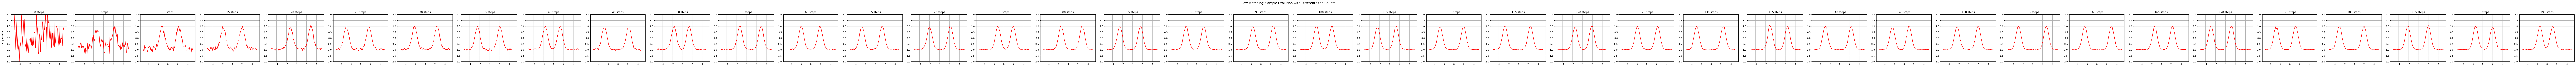

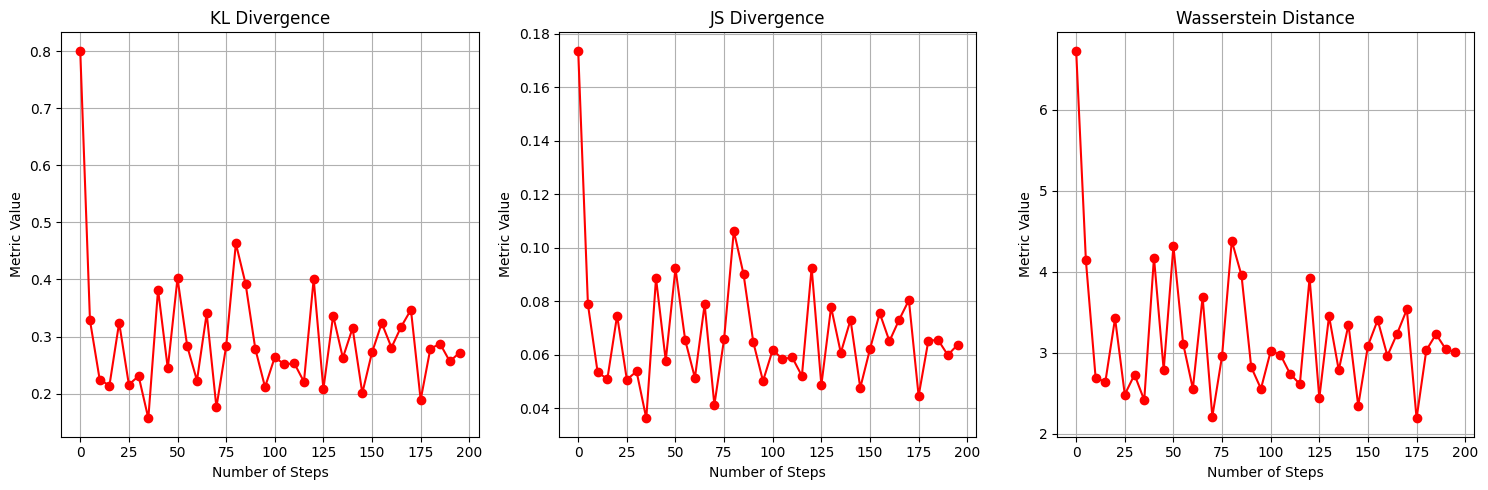

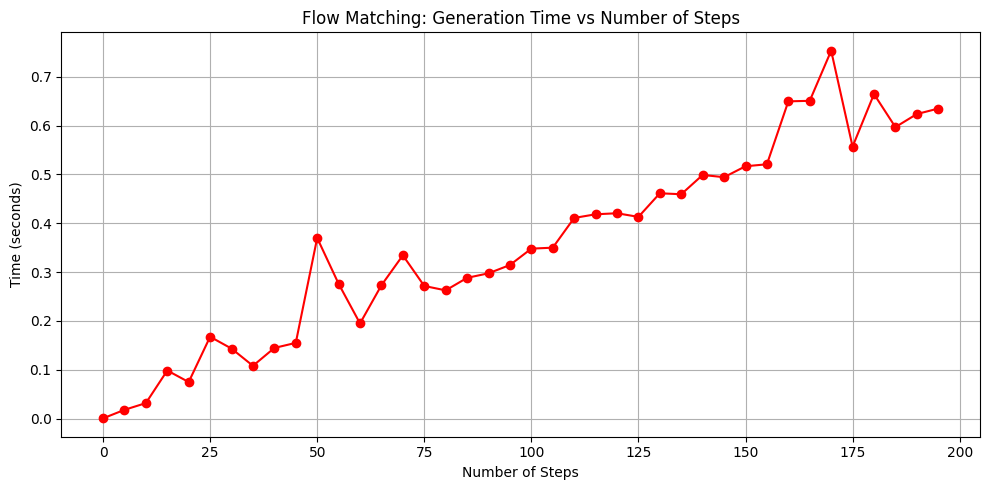

In [17]:
import time

# Define step counts to analyze
step_counts = [5*i for i in  range(40)]

# Run flow matching analysis
print("Running flow matching step count analysis...")
flow_analysis_results = analyze_flow_steps(
    flow_model=flow_model,
    x_coords=x_coords,
    test_data=test_data,
    device=device,
    step_counts=step_counts
)

# Visualize results
print("\nPlotting analysis results...")
plot_flow_step_analysis(flow_analysis_results, step_counts, x_coords)

Running flow matching step count analysis...

Generating samples with 2 steps...

Generating samples with 4 steps...

Generating samples with 8 steps...

Generating samples with 15 steps...

Generating samples with 25 steps...

Generating samples with 40 steps...

Generating samples with 60 steps...

Generating samples with 80 steps...

Generating samples with 100 steps...

Plotting analysis results...


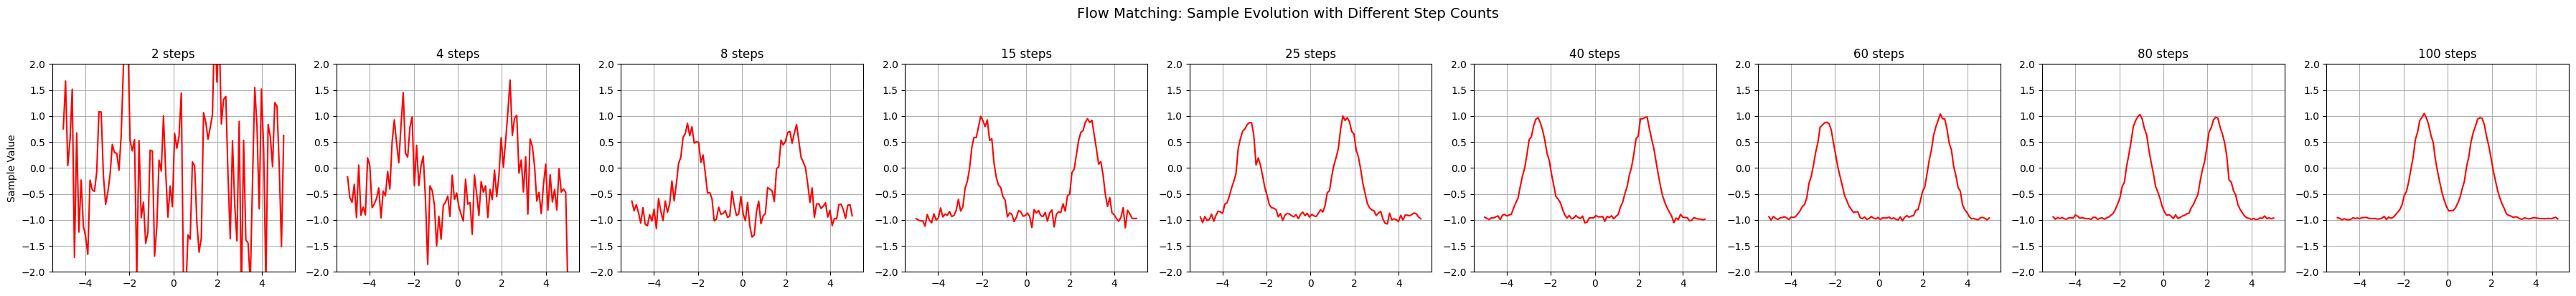

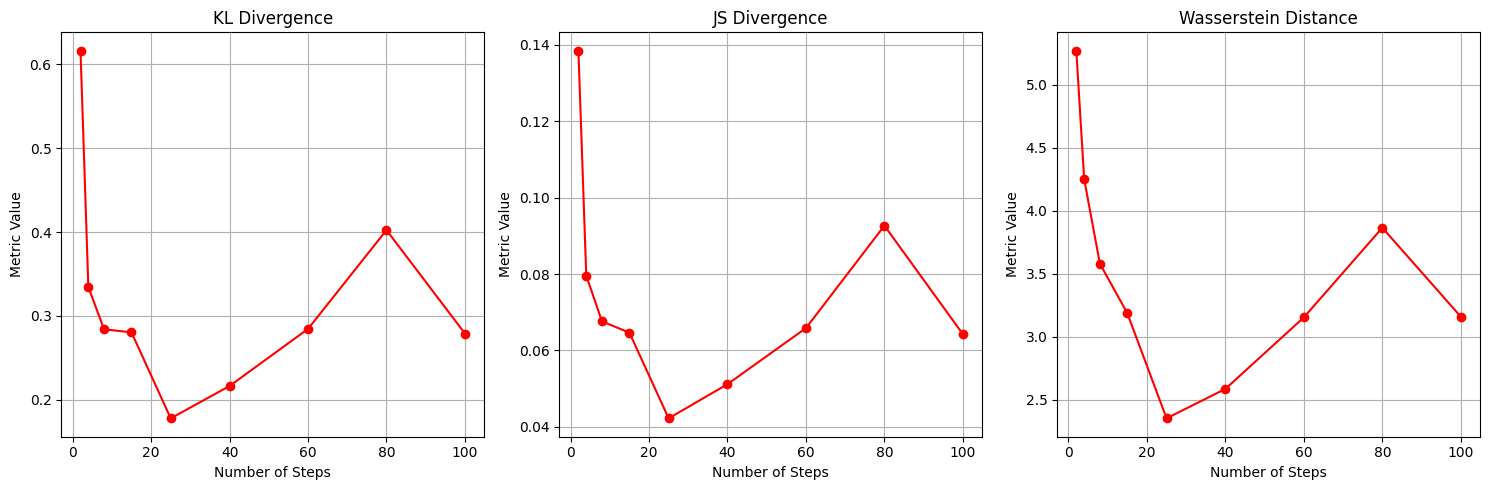

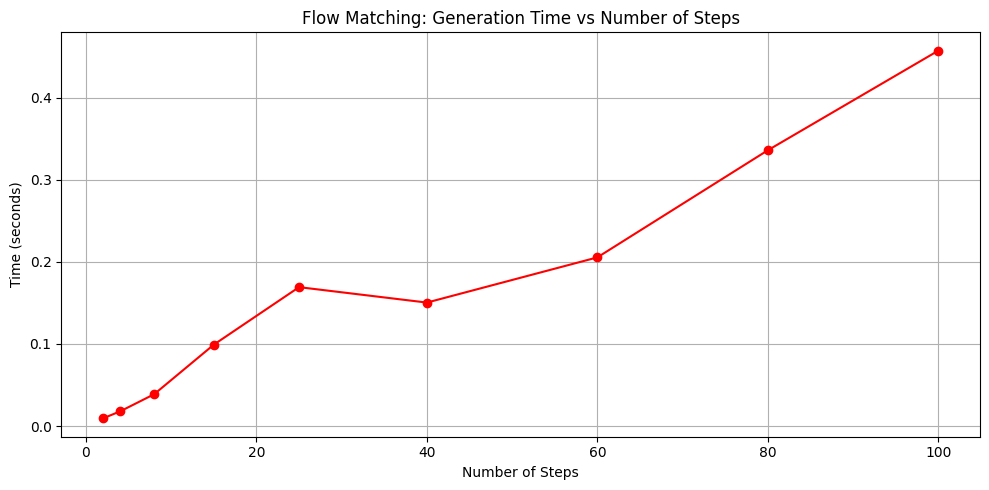

In [19]:
import time

# Define step counts to analyze
step_counts = [2, 4, 8, 15, 25, 40, 60, 80, 100]

# Run flow matching analysis
print("Running flow matching step count analysis...")
flow_analysis_results = analyze_flow_steps(
    flow_model=flow_model,
    x_coords=x_coords,
    test_data=test_data,
    device=device,
    step_counts=step_counts
)

# Visualize results
print("\nPlotting analysis results...")
plot_flow_step_analysis(flow_analysis_results, step_counts, x_coords)

Running flow matching step count analysis...

Generating samples with 0 steps...

Generating samples with 10 steps...

Generating samples with 20 steps...

Generating samples with 30 steps...

Generating samples with 40 steps...

Generating samples with 50 steps...

Generating samples with 60 steps...

Generating samples with 70 steps...

Generating samples with 80 steps...

Generating samples with 90 steps...

Generating samples with 100 steps...

Generating samples with 110 steps...

Generating samples with 120 steps...

Generating samples with 130 steps...

Generating samples with 140 steps...

Generating samples with 150 steps...

Generating samples with 160 steps...

Generating samples with 170 steps...

Generating samples with 180 steps...

Generating samples with 190 steps...

Generating samples with 200 steps...

Generating samples with 210 steps...

Generating samples with 220 steps...

Generating samples with 230 steps...

Generating samples with 240 steps...

Generating samp

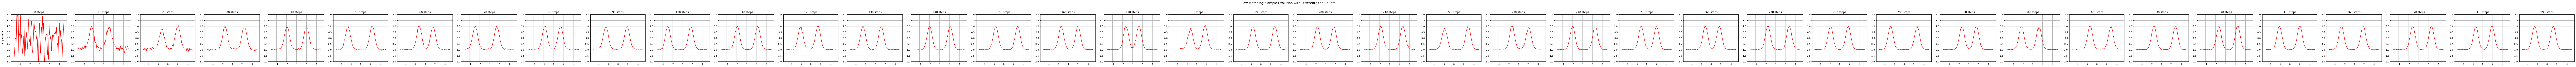

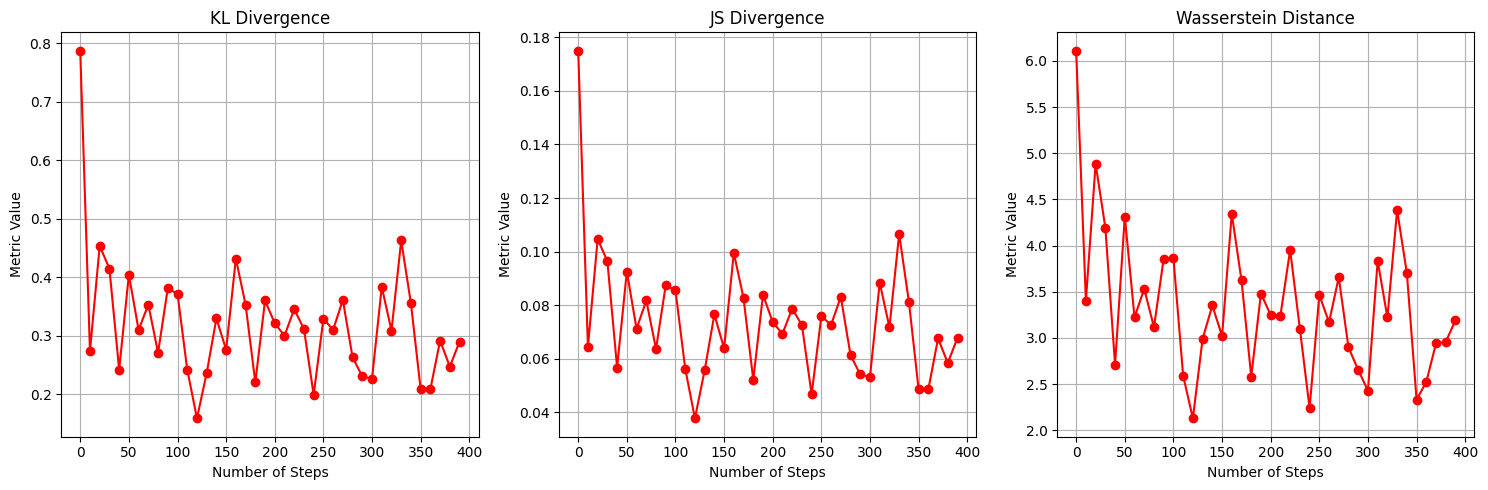

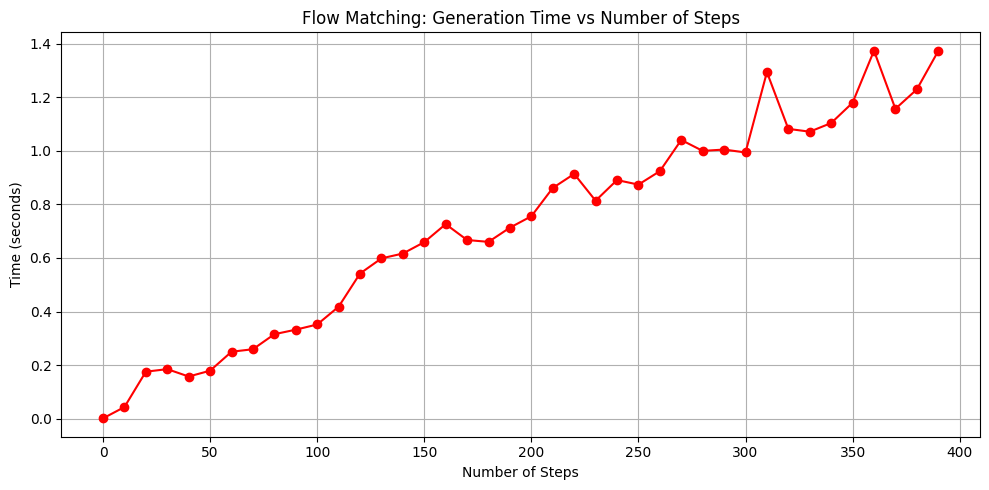

In [20]:
import time

# Define step counts to analyze
step_counts = [10*i for i in  range(40)]

# Run flow matching analysis
print("Running flow matching step count analysis...")
flow_analysis_results = analyze_flow_steps(
    flow_model=flow_model,
    x_coords=x_coords,
    test_data=test_data,
    device=device,
    step_counts=step_counts
)

# Visualize results
print("\nPlotting analysis results...")
plot_flow_step_analysis(flow_analysis_results, step_counts, x_coords)